In [11]:
import pandas as pd
from processor.processor import Processor as processor
from database.adatabase import ADatabase
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
from datetime import datetime

In [12]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [13]:
def calculate_technical_indicators(price):
    # Average Return
    price["average_return"] = price["adjclose"].pct_change(5).rolling(100).mean()
    price["prev_return"] = price["adjclose"].pct_change(5)
    
    # Coefficient of Variation
    price["coev"] = price["adjclose"].rolling(100).std() / price["adjclose"].rolling(100).mean()
    price["return_to_risk"] = price["prev_return"] / price["coev"]
    
    # Bollinger Bands
    price["bollinger"] = ((price["adjclose"].rolling(100).mean() - 2 * price["adjclose"].rolling(100).std()) - price["adjclose"]) / price["adjclose"]

    # RSI (Relative Strength Index)
    delta = price["adjclose"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    price["rsi"] = 100 - (100 / (1 + rs))

    # MACD (Moving Average Convergence Divergence)
    ema_12 = price["adjclose"].ewm(span=12, adjust=False).mean()
    ema_26 = price["adjclose"].ewm(span=26, adjust=False).mean()
    price["macd"] = ema_12 - ema_26
    price["signal_line"] = price["macd"].ewm(span=9, adjust=False).mean()

    # EMA (Exponential Moving Average)
    price["ema_20"] = price["adjclose"].ewm(span=20, adjust=False).mean()

    # ATR (Average True Range)
    high_low = price["adjhigh"] - price["adjlow"]
    high_close = np.abs(price["adjhigh"] - price["adjclose"].shift())
    low_close = np.abs(price["adjlow"] - price["adjclose"].shift())
    tr = high_low.combine(high_close, np.maximum).combine(low_close, np.maximum)
    price["atr"] = tr.rolling(14).mean()

    # Stochastic Oscillator
    low_14 = price["adjlow"].rolling(window=14).min()
    high_14 = price["adjhigh"].rolling(window=14).max()
    price["stochastic"] = (price["adjclose"] - low_14) / (high_14 - low_14) * 100

    # On-Balance Volume (OBV)
    price["obv"] = (np.sign(price["adjclose"].diff()) * price["volume"]).fillna(0).cumsum()

    # Chaikin Money Flow (CMF)
    money_flow_multiplier = ((price["adjclose"] - price["adjlow"]) - (price["adjhigh"] - price["adjclose"])) / (price["adjhigh"] - price["adjlow"])
    money_flow_volume = money_flow_multiplier * price["volume"]
    price["cmf"] = money_flow_volume.rolling(window=20).sum() / price["volume"].rolling(window=20).sum()

    # Williams %R
    price["williams_r"] = (price["adjhigh"].rolling(14).max() - price["adjclose"]) / (price["adjhigh"].rolling(14).max() - price["adjlow"].rolling(14).min()) * -100

    # Commodity Channel Index (CCI)
    typical_price = (price["adjhigh"] + price["adjlow"] + price["adjclose"]) / 3
    price["cci"] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).std())

    # Parabolic SAR
    # price["psar"] = ta.trend.psar(high=price["adjhigh"], low=price["adjlow"], close=price["adjclose"], step=0.02, max_step=0.2)

    return price

In [14]:
prices = []
market = ADatabase("market")
market.connect()
for ticker in tqdm(sp500["ticker"]):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker})).sort_values("date")
        price = calculate_technical_indicators(price)
        prices.append(price.dropna())
    except Exception as e:
        print(ticker, str(e))
        continue
market.disconnect()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:10<00:00, 46.81it/s]


In [15]:
prices = pd.concat(prices).sort_values("date")

In [16]:
factors = [
           "average_return"
            ,"prev_return"
           ,"coev"
           ,"bollinger","rsi","signal_line","ema_20","stochastic","atr","return_to_risk","obv","cmf","williams_r","cci"
          ]     

In [17]:
prices

,date,adjclose,adjlow,adjhigh,volume,ticker,average_return,prev_return,coev,return_to_risk,...,rsi,macd,signal_line,ema_20,atr,stochastic,obv,cmf,williams_r,cci
104,2022-12-19,122.1300,121.1600,123.770,2440223,MMM,-0.004208,-0.037209,0.092715,-0.401330,...,35.207101,-0.371184,0.352639,125.080685,3.203707,21.178821,-107128394.0,0.126196,-78.821179,-115.574872
104,2022-12-19,189.8900,187.8601,204.000,7321698,MRNA,0.014335,0.149942,0.157875,0.949755,...,57.498656,8.523732,7.944046,183.530033,14.018421,49.770516,18927472.0,-0.028892,-50.229484,66.278687
104,2022-12-19,155.3100,154.7200,157.380,747666,MAA,-0.003794,-0.050788,0.072485,-0.700672,...,39.908397,0.632604,1.425920,160.239233,4.435357,4.212781,869715.0,0.058409,-95.787219,-131.546878
104,2022-12-19,240.4500,238.7100,245.210,34123158,MSFT,-0.001564,-0.047760,0.077193,-0.618719,...,50.100301,1.931996,2.947636,246.799045,7.527314,6.903392,-552011174.0,-0.056499,-93.096608,-86.203793
104,2022-12-19,51.7200,51.1000,52.290,19318498,MU,-0.005674,-0.065583,0.070801,-0.926295,...,36.421725,-1.057541,-0.605934,54.737177,2.153279,9.090909,-97678254.0,-0.058154,-90.909091,-118.439731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,2024-07-22,33.0450,32.7450,33.110,2187296,KDP,0.004713,0.011478,0.058441,0.196409,...,54.408602,-0.234926,-0.303286,33.048454,0.492379,68.784530,-81576784.0,-0.156552,-31.215470,-8.556137
501,2024-07-22,15.6700,15.2300,15.715,7065188,KEY,0.006357,0.010968,0.043899,0.249838,...,69.541779,0.456557,0.312735,14.937252,0.442143,69.811321,-230586819.0,0.128410,-30.188679,70.333549
501,2024-07-22,841.9801,835.0400,845.500,136890,BLK,0.002187,0.023112,0.033180,0.696554,...,79.721275,14.682583,11.336074,813.626711,12.838114,85.700806,9514869.0,0.129899,-14.299194,98.920806
501,2024-07-22,158.9900,156.1300,160.820,316235,BLDR,-0.006193,0.037997,0.138878,0.273600,...,77.989252,2.450657,-0.734399,149.891626,5.763757,77.412219,93121068.0,0.042370,-22.587781,85.998402


In [18]:
analysis = []   
for factor in tqdm(factors):
    for ascending in [True,False]:
        default_portfolio = {"ticker":"","adjclose":0,"quantity":0,"buy_price":0}
        cash = 100
        portfolio = default_portfolio.copy()
        portfolios = []
        for date in prices["date"].unique():
            try:
                today = prices[prices["date"]==date]
                rec = today.sort_values(factor,ascending=ascending).iloc[0]
                if portfolio["ticker"] == "":
                    portfolio["ticker"] = rec["ticker"]
                    portfolio["adjclose"] = rec["adjclose"]
                    portfolio["quantity"] = cash / rec["adjclose"]
                    portfolio["buy_price"] = rec["adjclose"]
                    portfolio["date"] = date
                    cash = 0
                    portfolios.append(portfolio.copy())
                else:
                    ## update
                    updates = today[today["ticker"]==portfolio["ticker"]].iloc[0]
                    portfolio["adjclose"] = updates["adjclose"]
                    portfolio["date"] = date
                    if rec["ticker"] != portfolio["ticker"]:
                        cash = portfolio["adjclose"] * portfolio["quantity"]
                        portfolio["ticker"] = rec["ticker"]
                        portfolio["adjclose"] = rec["adjclose"]
                        portfolio["quantity"] = cash / rec["adjclose"]
                        portfolio["buy_price"] = rec["adjclose"]
                        portfolio["date"] = date
                        cash = 0
                        portfolios.append(portfolio.copy())
                    else:
                        portfolios.append(portfolio.copy())
            except Exception as e:
                print(str(e))
                continue
        states = pd.DataFrame(portfolios)
        states["pv"] = states["adjclose"] * states["quantity"]
        states["trade"] = states["ticker"] != states["ticker"].shift(-1)
        risk = states["pv"].std()
        analysis.append({"factor":factor,"ascending":ascending,"return":states.iloc[-1]["pv"]-100,"risk":risk})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00,  1.24s/it]


In [19]:
a = pd.DataFrame(analysis).sort_values("return",ascending=False)
a

,factor,ascending,return,risk
21,obv,False,639.087231,190.250123
1,average_return,False,510.659863,235.833480
3,prev_return,False,447.023931,121.540304
6,bollinger,True,440.809375,321.028413
5,coev,False,276.396411,153.244223
0,average_return,True,269.072708,68.694815
7,bollinger,False,171.770352,58.496833
22,cmf,True,101.696388,31.139792
9,rsi,False,84.643707,34.537639
13,ema_20,False,81.146591,20.810613


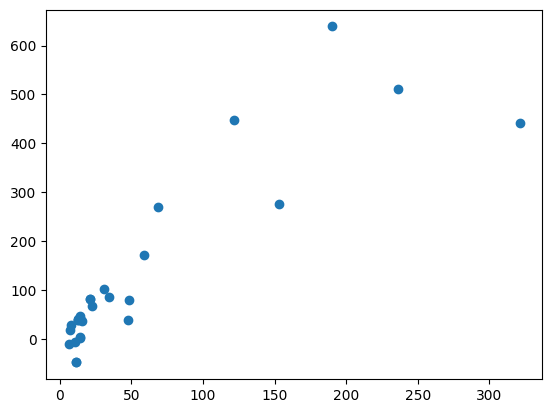

In [20]:
plt.scatter(a["risk"].values,a["return"].values)
plt.show()